# 02 - Vertex AI - AutoML


This builds a custom model with AutoML and deploys it to an Endpoint for predictions and explanations. 



## Setup

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'bootkon-2024'

In [3]:
REGION = 'us-central1'
# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'ml_datasets'
BQ_TABLE = 'ulb_fraud_detection'
NOTEBOOK = '02'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id Feedback service_account_email' # add more variables to the string with space delimiters

packages:

In [4]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [6]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{NOTEBOOK}"

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create Dataset (link to BigQuery table)

In [11]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}', 
    bq_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/112412469323/locations/us-central1/datasets/432348862762450944/operations/1118476588447432704
TabularDataset created. Resource name: projects/112412469323/locations/us-central1/datasets/432348862762450944
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/112412469323/locations/us-central1/datasets/432348862762450944')


---
## Train Model with AutoML

In [12]:
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))

In [13]:
column_specs = dict.fromkeys(column_specs, 'auto')

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [15]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [ ]:
# this job would take +2 hours,  depending on your infrastcuture
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7698922289047273472?project=112412469323
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trainingPipelines/7698922289047273472 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trainingPipelines/7698922289047273472 current state:
PipelineState.PIPELINE_STATE_PENDING
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trainingPipelines/7698922289047273472 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trainingPipelines/7698922289047273472 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trainingPipelines/7698922289047273472 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/112412469323/locations/us-central1/trai

## For the rest of the commands, because the training job takes signifiant time, we will show the results of the following commands on stage.

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.


Setup a model client for the model create by this notebook:

In [19]:
model.resource_name

'projects/112412469323/locations/us-central1/models/7735742700078497792'

In [20]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [21]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [22]:
geteval.metrics['auPrc']

0.99993

In [23]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [56522.0, 5.0, 0.0]
True Label =  1  has Predicted labels =  [10.0, 50.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [24]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [25]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.99994653
Label =  1 has auPrc =  0.91206044


---
## Endpoint and Deployment

In [27]:
# max 10 min
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/112412469323/locations/us-central1/endpoints/7868956230364954624/operations/6425247469675741184
Endpoint created. Resource name: projects/112412469323/locations/us-central1/endpoints/7868956230364954624
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/112412469323/locations/us-central1/endpoints/7868956230364954624')


In [28]:
# takes 45 min
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/112412469323/locations/us-central1/models/7735742700078497792 to Endpoint : projects/112412469323/locations/us-central1/endpoints/7868956230364954624
Deploy Endpoint model backing LRO: projects/112412469323/locations/us-central1/endpoints/7868956230364954624/operations/8352788110190313472
Endpoint model deployed. Resource name: projects/112412469323/locations/us-central1/endpoints/7868956230364954624


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [29]:
pred = bigquery.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [30]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Feedback,transaction_id,splits,service_account_email
0,140317.0,2.108409,0.134713,-1.958079,0.267756,0.744460,-0.448830,0.160228,-0.173553,0.529731,...,-0.191452,0.214235,-0.060176,-0.037058,1.98,0,very satisfied.,9a9c7342-f550-40a1-90af-0e4fa21af71a,TEST,112412469323-compute@developer.gserviceaccount...
1,133768.0,2.021321,-0.348230,-1.042850,0.586625,-0.402463,-1.004997,-0.065193,-0.213470,1.072862,...,0.043567,0.638116,-0.071060,-0.067976,16.00,0,very satisfied.,de5b79f4-6cf4-440d-9a6e-c8af1268c089,TEST,112412469323-compute@developer.gserviceaccount...
2,18552.0,-0.265284,0.081207,1.595559,-1.671107,-0.359368,-0.158713,-0.188054,0.271057,2.710338,...,-1.159539,-1.066871,0.283226,0.230268,11.85,0,very satisfied.,0255dfa7-6846-4644-b5d2-b773c6fe3c81,TEST,112412469323-compute@developer.gserviceaccount...
3,152499.0,0.068814,0.975844,-0.333363,-0.632815,0.966233,-0.492556,0.889090,0.036201,-0.364427,...,-0.469374,0.091150,0.221669,0.076151,8.08,0,very satisfied.,ce6b1c21-01de-4fd7-9eb1-fbc5f9e18685,TEST,112412469323-compute@developer.gserviceaccount...


In [31]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
newob

{'Time': 140317.0,
 'V1': 2.1084089279174805,
 'V2': 0.13471318781375885,
 'V3': -1.9580790996551514,
 'V4': 0.2677558362483978,
 'V5': 0.7444602847099304,
 'V6': -0.4488302171230316,
 'V7': 0.16022786498069763,
 'V8': -0.173553466796875,
 'V9': 0.5297311544418335,
 'V10': -0.3866994082927704,
 'V11': -1.0544523000717163,
 'V12': -0.01848548837006092,
 'V13': 0.19448408484458923,
 'V14': -0.8805928230285645,
 'V15': 0.2938603460788727,
 'V16': 0.43323707580566406,
 'V17': 0.30802515149116516,
 'V18': -0.20233836770057678,
 'V19': 0.20907585322856903,
 'V20': -0.140361949801445,
 'V21': -0.39812177419662476,
 'V22': -1.030430555343628,
 'V23': 0.27110952138900757,
 'V24': -0.12115343660116196,
 'V25': -0.19145162403583527,
 'V26': 0.21423456072807312,
 'V27': -0.06017601862549782,
 'V28': -0.037057679146528244,
 'Amount': 1.9800000190734863}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [32]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [33]:
prediction = endpoint.predict(instances=instances, parameters=parameters)

In [34]:
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.9998180866241455, 0.0001818900200305507]}], deployed_model_id='3781156716247252992', metadata=None, model_version_id='1', model_resource_name='projects/112412469323/locations/us-central1/models/7735742700078497792', explanations=None)

In [35]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [36]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [37]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99981808662414551,
        0.00018189002003055071
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "3781156716247252992",
  "model": "projects/112412469323/locations/us-central1/models/7735742700078497792",
  "modelDisplayName": "02_ulb_fraud_detection_20240416084855",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [38]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9998180866241455, 0.0001818900200305507]}]



## Explanations
Interpretation Guide
https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [39]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [40]:
explanation.predictions

[{'classes': ['0', '1'],
  'scores': [0.9998180866241455, 0.0001818900200305507]}]

In [41]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.999780535697937
instance output 0.9998180866241455
output_index [0]
output display value 0
approximation error 0.007348579035397098


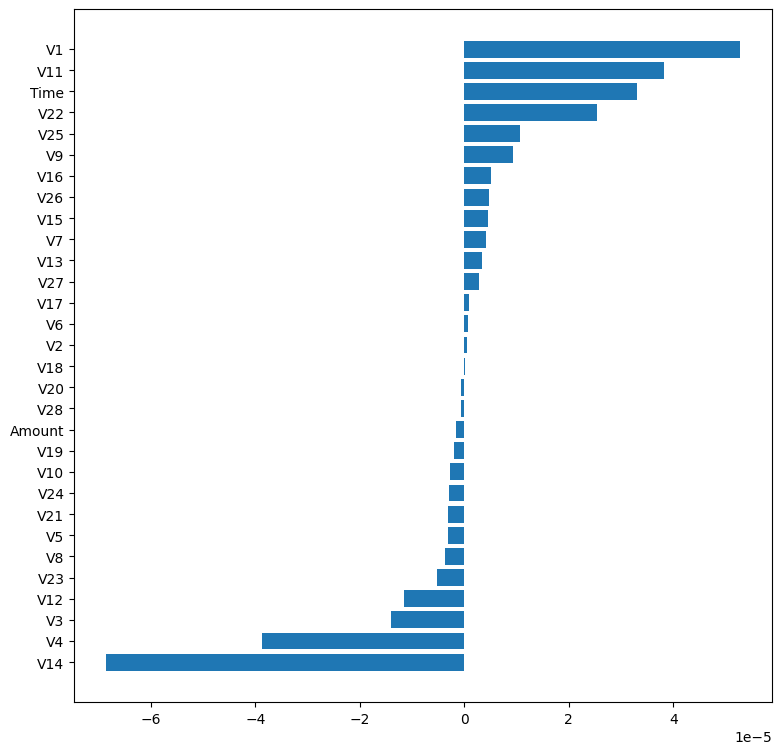

In [42]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
# this job would take +2 hours,  depending on your infrastcuture
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/112412469323/locations/us-central1/batchPredictionJobs/8687954988464340992
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/112412469323/locations/us-central1/batchPredictionJobs/8687954988464340992')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/8687954988464340992?project=112412469323
BatchPredictionJob projects/112412469323/locations/us-central1/batchPredictionJobs/8687954988464340992 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/112412469323/locations/us-central1/batchPredictionJobs/8687954988464340992 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/112412469323/locations/us-central1/batchPredictionJobs/8687954988464340992 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/112412469323/locations/us-central1/batchPredictionJobs/